<a href="https://colab.research.google.com/github/Karthikt04/NM/blob/main/MyZoomCFV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Install dependencies
!pip install --quiet transformers datasets torch scikit-learn pandas openpyxl gradio

In [6]:
#Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
import torch

In [7]:
# Upload and load data
from google.colab import files
print("Upload 'train.xlsx':")
_ = files.upload()
print("Upload 'evaluation.xlsx':")
_ = files.upload()

df_train = pd.read_excel('train.xlsx')
df_eval = pd.read_excel('evaluation.xlsx')

Upload 'train.xlsx':


Saving train.xlsx to train.xlsx
Upload 'evaluation.xlsx':


Saving evaluation.xlsx to evaluation.xlsx


In [9]:
# Inspect & balance
# Drop NaNs
df_train.dropna(subset=['text','reason','label'], inplace=True)
print(df_train['label'].value_counts())

# (Optional) simple augmentation for negative class:
neg_df = df_train[df_train.label == 0]
pos_df = df_train[df_train.label == 1]
# create mismatched pairs = shuffle reasons
shuffled = pos_df.copy()
shuffled['reason'] = np.random.permutation(shuffled['reason'].values)
df_aug = pd.concat([df_train, shuffled]).reset_index(drop=True)
print("After augmentation:", df_aug['label'].value_counts())

label
1    2061
Name: count, dtype: int64
After augmentation: label
1    4122
Name: count, dtype: int64


In [11]:
# Preprocessing helper (if needed)
def preprocess_text(text):
    return text.strip()

df_aug['text'] = df_aug['text'].apply(preprocess_text)

In [12]:
# Tokenization
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def tokenize_fn(batch):
    return tokenizer(batch['text'], batch['reason'], truncation=True, padding='max_length', max_length=128)

# Convert to Hugging Face Dataset
hf_train = Dataset.from_pandas(df_aug)
hf_eval = Dataset.from_pandas(df_eval)

# Tokenize
hf_train = hf_train.map(tokenize_fn, batched=True)
hf_eval = hf_eval.map(tokenize_fn, batched=True)

# Set format
hf_train.set_format(type='torch', columns=['input_ids','attention_mask','label'])
hf_eval.set_format(type='torch', columns=['input_ids','attention_mask','label'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/4122 [00:00<?, ? examples/s]

Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

In [13]:
# Model & TrainingArguments
import os
os.environ["WANDB_DISABLED"] = "true"
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    report_to="none",
    save_total_limit=1
)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# Metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    cm = confusion_matrix(labels, preds)
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

In [17]:
# Trainer setup & train
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=hf_train,
    eval_dataset=hf_eval,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

<ipython-input-17-31853e6a2f3b>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000000,7.384099,0.333444,0.333444,1.000000,0.500125
2,0.000000,7.844433,0.333444,0.333444,1.000000,0.500125
3,0.000000,7.982692,0.333444,0.333444,1.000000,0.500125


TrainOutput(global_step=1548, training_loss=0.0018065778398339216, metrics={'train_runtime': 516.7907, 'train_samples_per_second': 23.928, 'train_steps_per_second': 2.995, 'total_flos': 813407827645440.0, 'train_loss': 0.0018065778398339216, 'epoch': 3.0})

{'eval_loss': 7.384099006652832, 'eval_accuracy': 0.33344444444444443, 'eval_precision': 0.33344444444444443, 'eval_recall': 1.0, 'eval_f1': 0.5001249895842013, 'eval_runtime': 62.3387, 'eval_samples_per_second': 144.373, 'eval_steps_per_second': 18.047, 'epoch': 3.0}


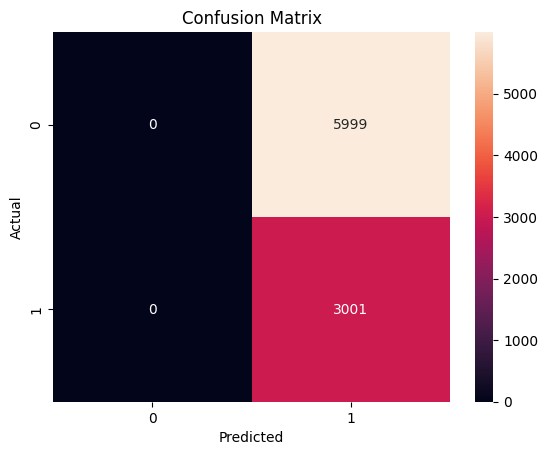

In [18]:
# Evaluate & visualize
metrics = trainer.evaluate()
print(metrics)

# Confusion matrix
import seaborn as sns, matplotlib.pyplot as plt
cm = confusion_matrix(hf_eval['label'], np.argmax(trainer.predict(hf_eval).predictions, axis=1))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [21]:
# Save model
!huggingface-cli login  # Log in to your Hugging Face account
model.push_to_hub('my-zoom-fb-validation-model')


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Theleebebe/my-zoom-fb-validation-model/commit/8f8fd60d4c839ac033003fcd38ff0301d4987a25', commit_message='Upload BertForSequenceClassification', commit_description='', oid='8f8fd60d4c839ac033003fcd38ff0301d4987a25', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Theleebebe/my-zoom-fb-validation-model', endpoint='https://huggingface.co', repo_type='model', repo_id='Theleebebe/my-zoom-fb-validation-model'), pr_revision=None, pr_num=None)

In [23]:
import torch

# Move model → GPU/CPU and set eval mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
def predict_fn(text, reason):
    try:
        inputs = tokenizer(
            text,
            reason,
            truncation=True,
            padding='max_length',
            max_length=128,
            return_tensors='pt'
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=1)[0].cpu().numpy()

        return {"Aligned (1)": float(probs[1]), "Not Aligned (0)": float(probs[0])}
    except Exception as e:
        return {"Error": str(e)}


In [24]:
import gradio as gr

iface = gr.Interface(
    fn=predict_fn,
    inputs=[
        gr.Textbox(lines=2, placeholder="Enter the output text here…", label="Output"),
        gr.Textbox(lines=2, placeholder="Enter the feedback/reason here…", label="Reason")
    ],
    outputs=gr.Label(num_top_classes=2),
    title="My Zoom: Feedback Validator"
)

iface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://68b3a105339968f811.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
